In [1]:
import os 
import sys 
import time 
import numpy as np
import json
import tpch_param as tp 

In [2]:
DET_PARAMS_FNAME = "./training_params/detparams_n10.json"
DET_PARAMS = None
with open(DET_PARAMS_FNAME, 'rb') as f:
    DET_PARAMS = json.load(f)
    print(len(DET_PARAMS))

training_fnames = ['./training_results/'+x for x in os.listdir('./training_results') if 'sf10_' in x and 'main' in x]
len(training_fnames)
print(training_fnames)

def get_spark_params(result_dict):
    param_vals = []
    for param in tp.SPARK_PARAMETERS:
        for p in result_dict['params']:
            if p['name'] == param['name']:
                param_vals.append(p['cur_value'])
    return tuple(param_vals)

880
['./training_results/sf10_n10_det_main0.txt', './training_results/sf10_n10_det_main_fix.txt', './training_results/sf10_n1_rand_main0.txt', './training_results/sf10_n1_rand_main1.txt', './training_results/sf10_n1_rand_main2.txt', './training_results/sf10_n1_rand_main3.txt', './training_results/sf10_n1_rand_main4.txt', './training_results/sf10_n1_rand_main5.txt', './training_results/sf10_n1_rand_main6.txt', './training_results/sf10_n1_rand_main7.txt', './training_results/sf10_n1_rand_main8.txt', './training_results/sf10_n1_rand_main9.txt', './training_results/sf10_n1_rand_main_fix.txt']


In [3]:
defaults = tuple(a['default_value'] for a in tp.SPARK_PARAMETERS)
defaults

(1,
 '1g',
 2,
 1,
 '1g',
 '48m',
 'true',
 'true',
 '32k',
 '4m',
 'true',
 0.6,
 '128',
 'false',
 'lz4',
 1,
 100,
 200,
 0.5)

In [4]:
fname_numdata = {}
fname_numdet = {}
deterministic_data = {}

for fname in training_fnames:
    with open(fname,'r') as file:
        lines = file.readlines()
        fname_numdata[fname] = len(lines)
        deterministic_data[fname] = {}
        
        for k in DET_PARAMS:
            if int(k) < len(lines):
                deterministic_data[fname][k] = eval(lines[int(k)])
        fname_numdet[fname] = len(deterministic_data[fname])
        if fname_numdet[fname] < 5:
            del fname_numdet[fname]
            del deterministic_data[fname]
            
print(sum(fname_numdata.values()))
print(fname_numdata)
print(fname_numdet)

3391
{'./training_results/sf10_n10_det_main0.txt': 275, './training_results/sf10_n10_det_main_fix.txt': 322, './training_results/sf10_n1_rand_main0.txt': 236, './training_results/sf10_n1_rand_main1.txt': 352, './training_results/sf10_n1_rand_main2.txt': 237, './training_results/sf10_n1_rand_main3.txt': 92, './training_results/sf10_n1_rand_main4.txt': 120, './training_results/sf10_n1_rand_main5.txt': 238, './training_results/sf10_n1_rand_main6.txt': 320, './training_results/sf10_n1_rand_main7.txt': 303, './training_results/sf10_n1_rand_main8.txt': 291, './training_results/sf10_n1_rand_main9.txt': 258, './training_results/sf10_n1_rand_main_fix.txt': 347}
{'./training_results/sf10_n10_det_main0.txt': 275, './training_results/sf10_n10_det_main_fix.txt': 322, './training_results/sf10_n1_rand_main0.txt': 236, './training_results/sf10_n1_rand_main1.txt': 352, './training_results/sf10_n1_rand_main2.txt': 237, './training_results/sf10_n1_rand_main3.txt': 92, './training_results/sf10_n1_rand_mai

In [5]:
det_params = {}
det_rt = {}
for fname, data in deterministic_data.items():
    det_params[fname] = []
    det_rt[fname] = []
    for result_dict in data.values():
        det_params[fname].append(get_spark_params(result_dict))
        if result_dict['runtimes']:
            det_rt[fname].append(result_dict['runtimes']['total']) # total
    if not det_params[fname]:
        print(fname)
        del det_params[fname]
        del det_rt[fname]
prev_fname = fname
for fname in det_params:
    assert 'det' not in fname or det_params[fname][0] == defaults, f'{det_params[fname][0]} !=\n{defaults}'
    #assert str(det_params[fname]) == str(det_params[prev_fname]), fname + " " + prev_fname
    print(fname, '\n',det_rt[fname][0], det_rt[fname][-1], max(det_rt[fname]), min(det_rt[fname]), len(det_rt[fname]))

./training_results/sf10_n10_det_main0.txt 
 256.333726644516 177.61606073379517 644.3383266925812 112.67993021011353 270
./training_results/sf10_n10_det_main_fix.txt 
 191.07653999328613 184.0608582496643 209.71132683753967 119.95743799209595 316
./training_results/sf10_n1_rand_main0.txt 
 229.00366067886353 299.8822772502899 712.7956547737122 154.3426637649536 229
./training_results/sf10_n1_rand_main1.txt 
 230.9756691455841 189.38307571411133 481.46935844421387 113.8074905872345 321
./training_results/sf10_n1_rand_main2.txt 
 206.01829862594604 959.9718296527863 962.8571968078613 111.53646945953369 215
./training_results/sf10_n1_rand_main3.txt 
 499.5033097267151 939.5867567062378 1071.9683856964111 433.37639260292053 86
./training_results/sf10_n1_rand_main4.txt 
 493.91465878486633 853.9527714252472 1156.0497951507568 403.3373279571533 87
./training_results/sf10_n1_rand_main5.txt 
 856.3335855007172 191.55547094345093 1206.5933125019073 115.62407279014587 183
./training_results/sf10

In [6]:
# how many different param combos have we tried?
fname_num_params = {}
fname_valid = {}
for fname in training_fnames:
    with open(fname,'r') as file:
        lines = file.readlines()
        fname_num_params[fname] = set()
        fname_valid[fname] = 0
        for result_dict in lines:
            result_dict = eval(result_dict)
            fname_num_params[fname].add(get_spark_params(result_dict))
            fname_valid[fname] += 1 if result_dict['runtimes'] else 0


In [7]:
print(sum([len(x) for x in fname_num_params.values()]))
for fname, vals in fname_num_params.items():
    print(fname[18:60], '\nnum unique params', len(vals), 'total runs',fname_numdata[fname] , 'valid runs', fname_valid[fname])

2970
/sf10_n10_det_main0.txt 
num unique params 88 total runs 275 valid runs 270
/sf10_n10_det_main_fix.txt 
num unique params 88 total runs 322 valid runs 316
/sf10_n1_rand_main0.txt 
num unique params 236 total runs 236 valid runs 229
/sf10_n1_rand_main1.txt 
num unique params 352 total runs 352 valid runs 321
/sf10_n1_rand_main2.txt 
num unique params 237 total runs 237 valid runs 215
/sf10_n1_rand_main3.txt 
num unique params 92 total runs 92 valid runs 86
/sf10_n1_rand_main4.txt 
num unique params 120 total runs 120 valid runs 87
/sf10_n1_rand_main5.txt 
num unique params 238 total runs 238 valid runs 183
/sf10_n1_rand_main6.txt 
num unique params 320 total runs 320 valid runs 301
/sf10_n1_rand_main7.txt 
num unique params 303 total runs 303 valid runs 286
/sf10_n1_rand_main8.txt 
num unique params 291 total runs 291 valid runs 270
/sf10_n1_rand_main9.txt 
num unique params 258 total runs 258 valid runs 242
/sf10_n1_rand_main_fix.txt 
num unique params 347 total runs 347 valid run

In [8]:
#det_rt

In [9]:
for fname in det_rt:
    all_runs = []
    runs = []
    for run in det_rt[fname]:
        all_runs.append(run)
        runs.append(run)
    print(fname, 'avg ', round(np.average(runs), 5), 'median', round(np.median(runs), 5), 'range ', round(max(runs)-min(runs),5), 'std ', round(np.std(runs), 5))
print('overall runs avg ', round(np.average(all_runs), 5), 'median', round(np.median(all_runs), 5), 'range ', round(max(all_runs)-min(all_runs),5), 'std ', round(np.std(all_runs), 5))
              
        

./training_results/sf10_n10_det_main0.txt avg  216.12191 median 209.05179 range  531.6584 std  48.18914
./training_results/sf10_n10_det_main_fix.txt avg  183.00716 median 184.25561 range  89.75389 std  12.23586
./training_results/sf10_n1_rand_main0.txt avg  256.96224 median 220.25458 range  558.45299 std  83.89144
./training_results/sf10_n1_rand_main1.txt avg  174.3179 median 184.16709 range  367.66187 std  44.50412
./training_results/sf10_n1_rand_main2.txt avg  269.63879 median 193.02504 range  851.32073 std  219.05561
./training_results/sf10_n1_rand_main3.txt avg  708.68609 median 673.82862 range  638.59199 std  215.53109
./training_results/sf10_n1_rand_main4.txt avg  694.548 median 787.6109 range  752.71247 std  211.5243
./training_results/sf10_n1_rand_main5.txt avg  314.86495 median 186.07126 range  1090.96924 std  276.96524
./training_results/sf10_n1_rand_main6.txt avg  192.22437 median 193.094 range  652.70876 std  65.06847
./training_results/sf10_n1_rand_main7.txt avg  203.80186

['sf10_n10_det_main0.txt', 'sf10_n10_det_main_fix.txt', 'sf10_n1_rand_main0.txt', 'sf10_n1_rand_main1.txt', 'sf10_n1_rand_main2.txt', 'sf10_n1_rand_main3.txt', 'sf10_n1_rand_main4.txt', 'sf10_n1_rand_main5.txt', 'sf10_n1_rand_main6.txt', 'sf10_n1_rand_main7.txt', 'sf10_n1_rand_main8.txt', 'sf10_n1_rand_main9.txt', 'sf10_n1_rand_main_fix.txt', 'sf10_training_data.txt', 'sf1_n10_det_main.txt', 'sf1_n10_det_main2.txt', 'sf1_n1_det_main2.txt', 'sf1_n1_rand_main1.txt', 'sf1_n1_rand_main2.txt', 'sf1_n1_rand_main3.txt', 'sf1_n1_rand_main4.txt', 'sf1_n1_rand_main5.txt', 'sf1_n20_compare_test3.txt', 'sf1_n5_det_main2.txt', 'sf300_n1_det_testing.txt', 'sf324_n1_det_hoped_laptop.txt', 'sf324_n1_det_hope_laptop.txt', 'sf324_n500_det_local_individual_job.txt'] 

['./training_results/sf10_n10_det_main0.txt', './training_results/sf10_n10_det_main_fix.txt', './training_results/sf1_n10_det_main.txt', './training_results/sf1_n10_det_main2.txt', './training_results/sf1_n1_det_main2.txt', './training_resu

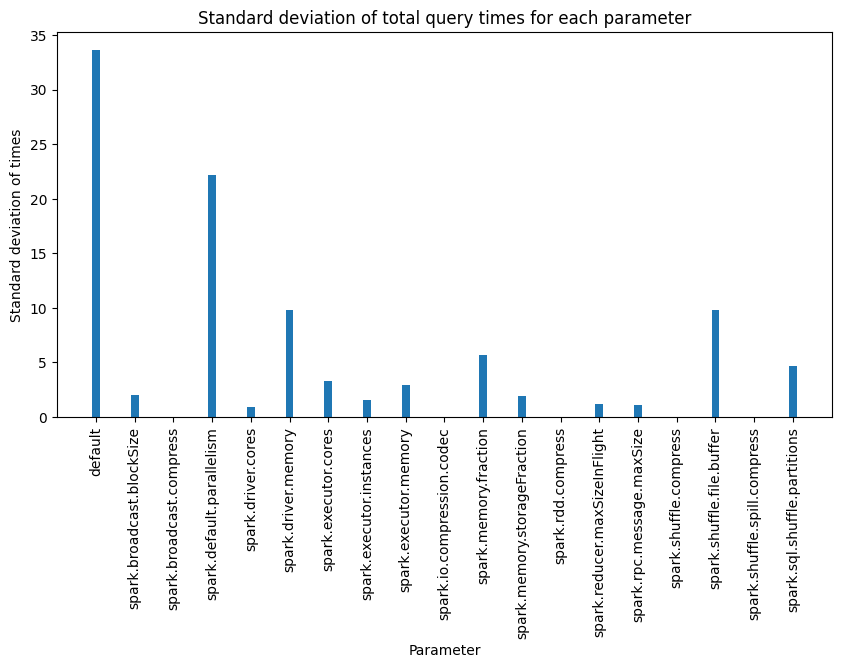

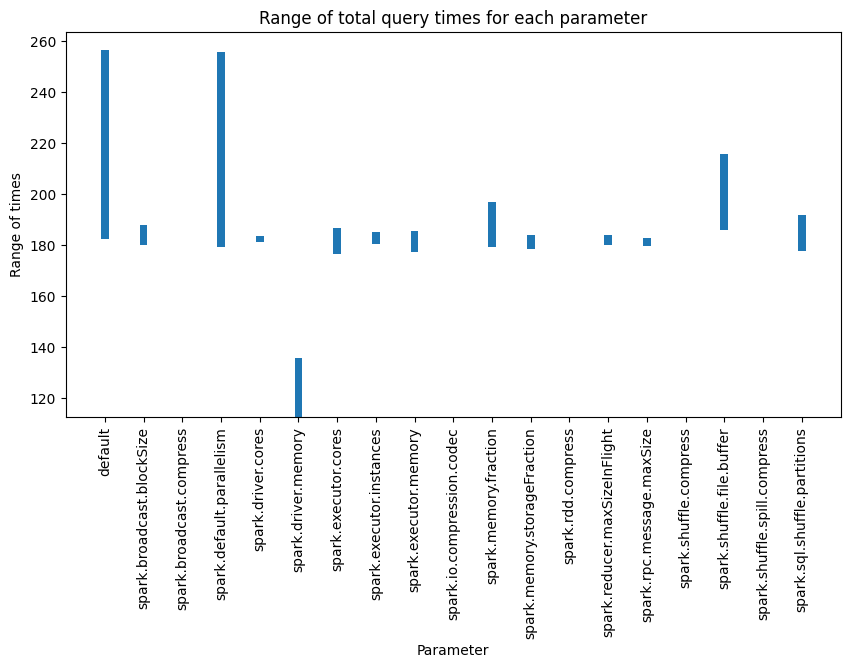

deftotal [191.07653999328613, 186.319504737854, 183.99108695983887, 184.63133668899536]
default, min: 183.99109, max: 191.07654, median 185.47542, avg: 186.50462  default: (183.99109, 191.07654)
sf10_n10_det_main_fix 322


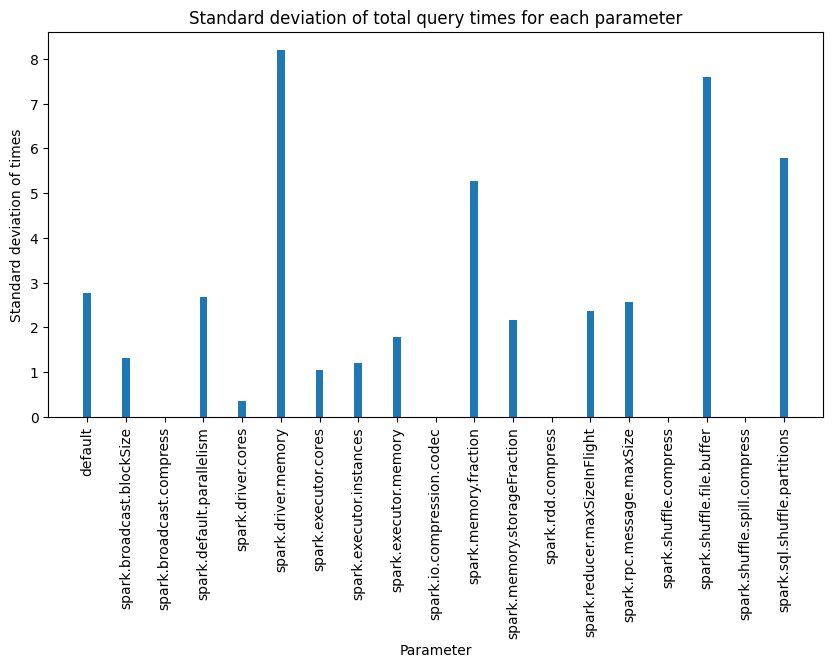

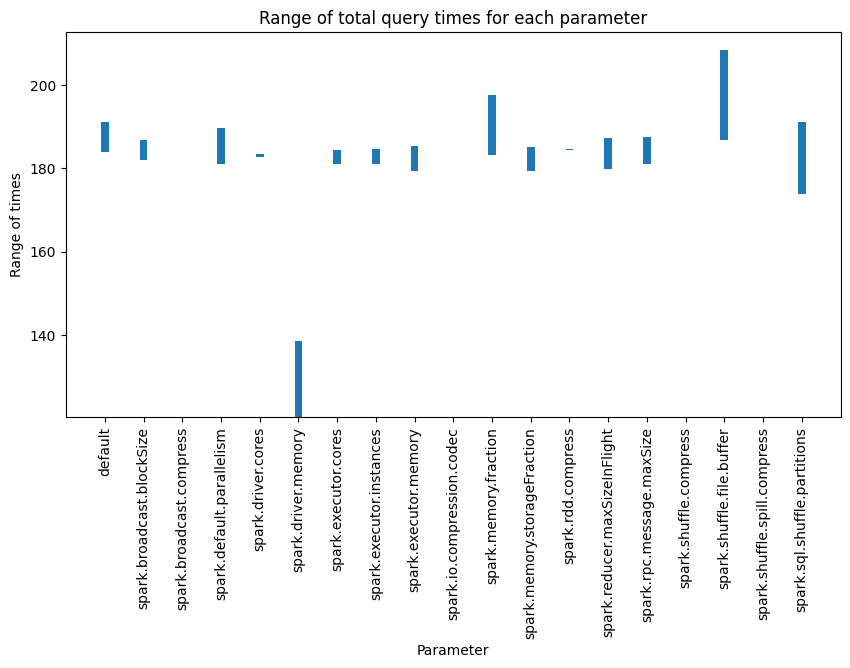

deftotal [91.26099371910095, 85.19530129432678, 84.05660152435303, 87.09424328804016, 91.69003963470459, 42.23882794380188, 42.6687388420105, 43.453712940216064, 42.586594581604004, 43.894917249679565]
default, min: 42.23883, max: 91.69004, median 63.97576, avg: 65.414  default: (42.23883, 91.69004)
sf1_n10_det_main 831


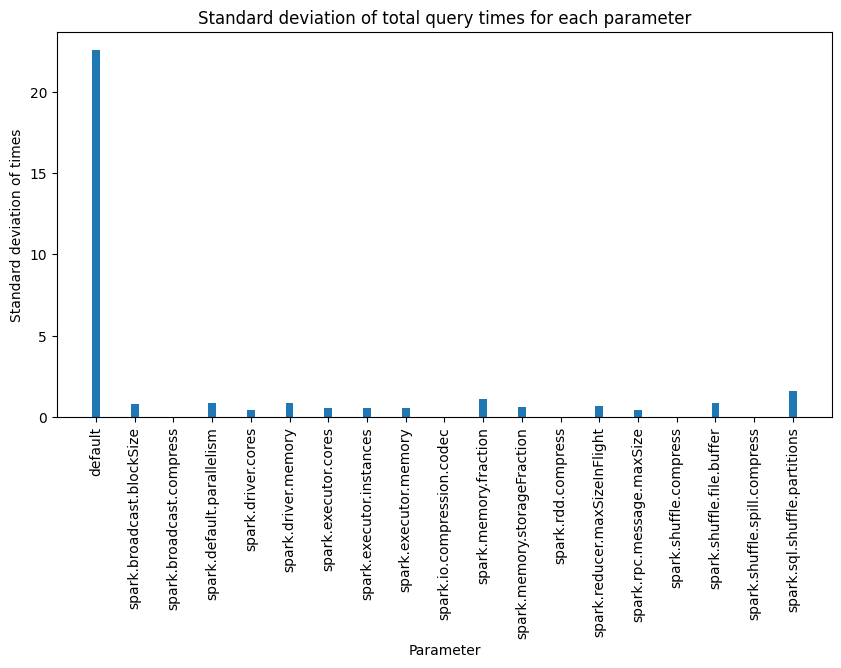

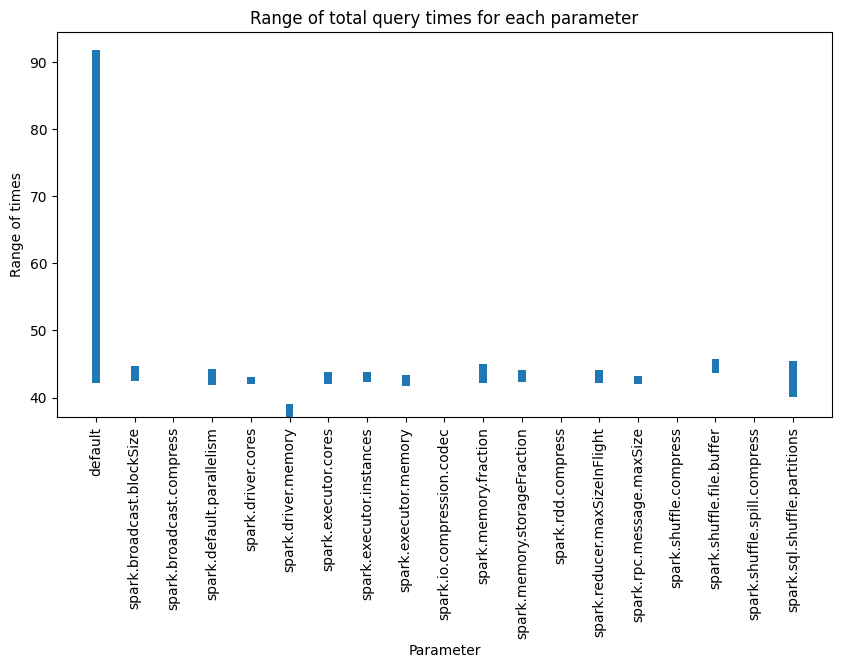

deftotal [123.33979225158691, 140.57317280769348, 50.346794843673706, 50.17508149147034, 49.330902099609375, 49.20719623565674, 50.940053939819336, 50.42170023918152, 49.633732318878174, 43.64210057258606]
default, min: 43.6421, max: 140.57317, median 50.26094, avg: 65.76105  default: (43.6421, 140.57317)
sf1_n10_det_main2 880


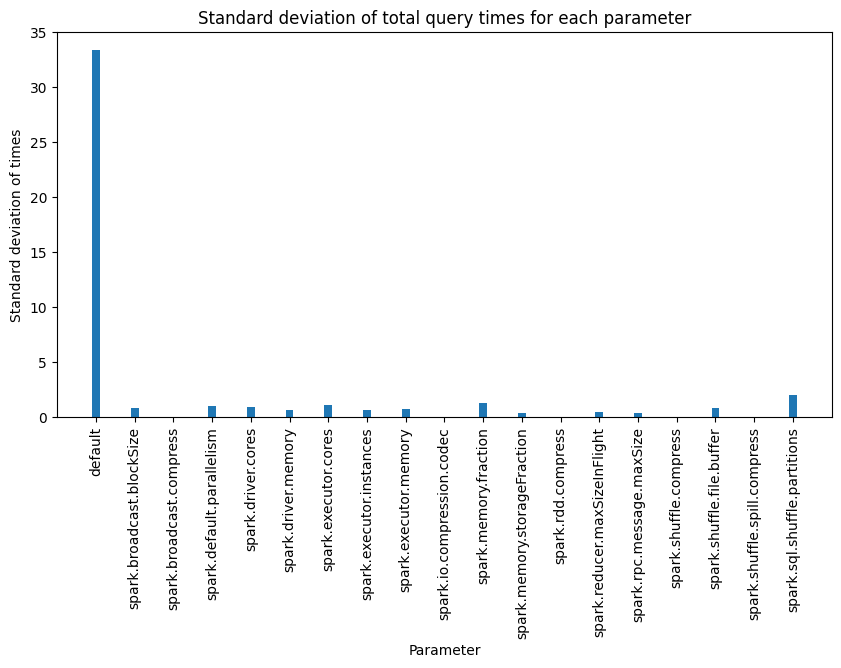

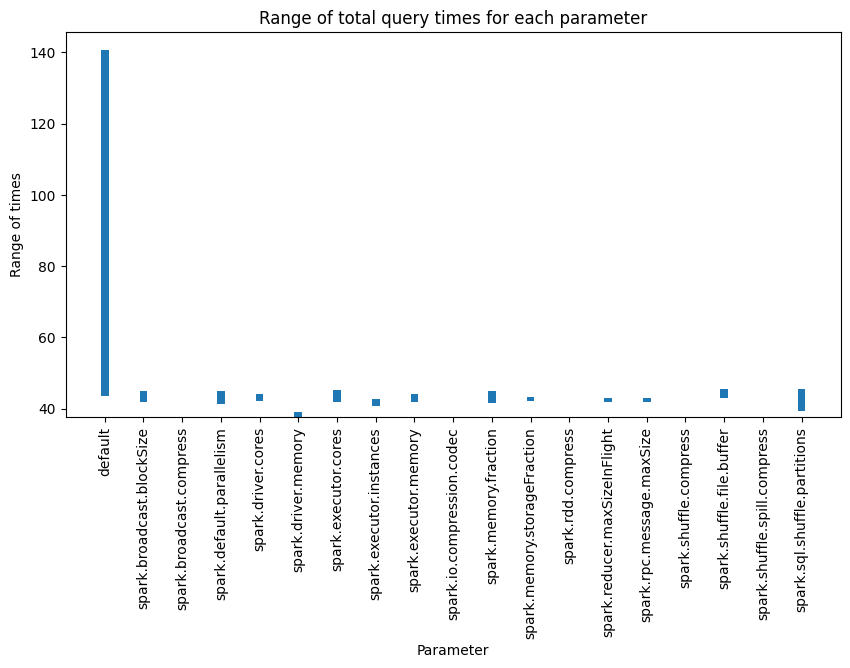

deftotal [386.0415635108948]
default, min: 386.04156, max: 386.04156, median 386.04156, avg: 386.04156  default: (386.04156, 386.04156)
sf1_n1_det_main2 50


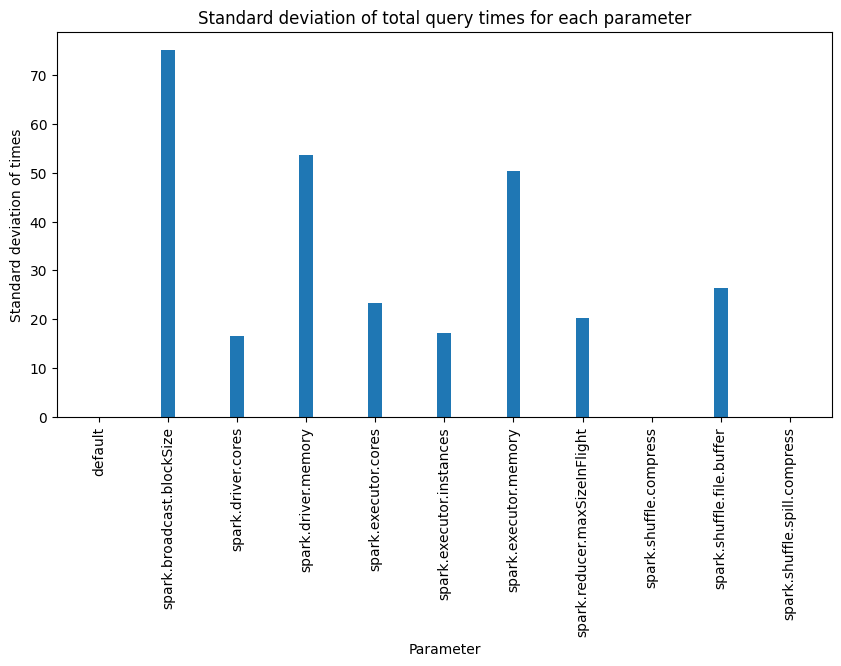

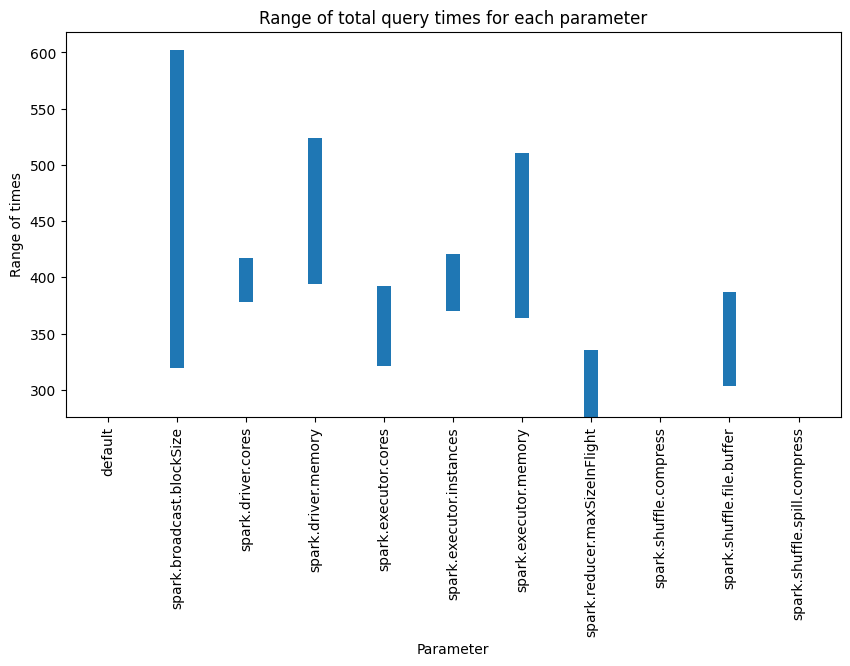

deftotal [382.4356498718262]
default, min: 382.43565, max: 382.43565, median 382.43565, avg: 382.43565  default: (382.43565, 382.43565)
sf1_n5_det_main2 50


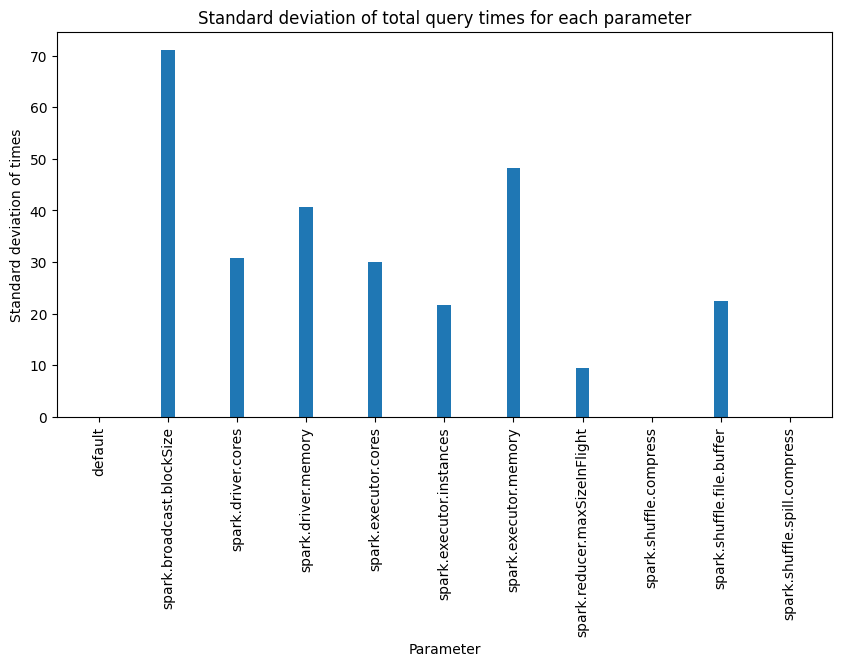

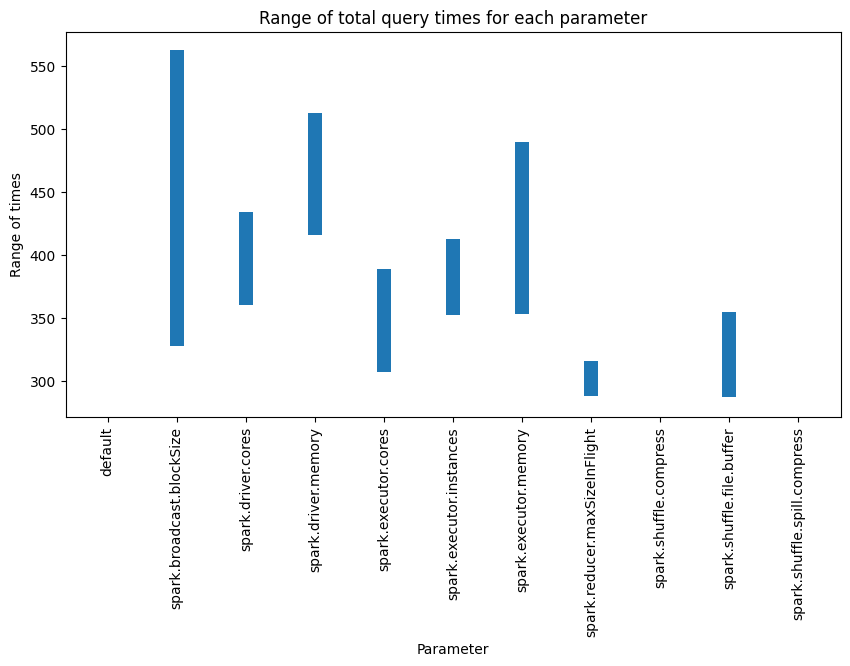

In [10]:
#training_fnames = ['./training_results/'+x for x in os.listdir('./training_results') if 'json' in x and 'test_clear_ports' in x]
#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'
#training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'json' in x and 'nobackup_deterministic_raw_runtimes' in x]
direc = './training_results'
print (os.listdir(direc), "\n")
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'det_main' in x]
#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'

len(training_fnames)
print(training_fnames)
for FNAME in  training_fnames:
    import json
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    
    with open(FNAME,'r') as file:
        try:
            file_data = file.readlines()
        except Exception as e:
            print(FNAME, "load error")
            print(e)
            continue
    if len(file_data) < 5:
        continue

    class Parameter:
        def __init__(self, name):
            self.name = name
            self.val_to_results = {}

        def add(self, param_val, results):
            self.val_to_results[param_val] = results

        def get_total(self, param_val):
            if param_val in self.val_to_results:
                return self.val_to_results[param_val]["total"] # change

        def get_param_vals(self):
            return set(self.val_to_results.keys())

    param_name_to_param_obj = {}

    def populate_params():
        #analyze one file

        with open(FNAME, "r") as file:
            for line in file:
                d = eval(line)
       
                params = [p for p in d["params"] if p['spark_param']]
                runtimes = d["runtimes"]
                if len(runtimes) == 0:
                    continue

                all_default = True
                for p in params:
                    if str(p['cur_value']) != str(p['default_value']):
                        varying_param = p['name']
                        all_default = False
                        break
                if all_default:
                    if 'default' not in param_name_to_param_obj:
                        param_name_to_param_obj["default"] = Parameter('default')

                    obj = param_name_to_param_obj["default"]
                    obj.add(len(obj.val_to_results), runtimes)
                    continue

                if varying_param not in param_name_to_param_obj:
                    param_name_to_param_obj[varying_param] = Parameter(varying_param)
                obj = param_name_to_param_obj[varying_param]
                assert "total" in runtimes
                obj.add(p['cur_value'], runtimes)

    def analyze_results():
        populate_params()
        default = param_name_to_param_obj["default"]
        default_total = [default.get_total(k) for k in default.get_param_vals()]
        print('deftotal',default_total)
        mins = []
        names = []
        diffs = []
        stds = []
        for p in sorted(param_name_to_param_obj):
            min_runtime = float("inf")
            max_runtime = -float("inf")
            times = []
            if p != 'default':
                obj = param_name_to_param_obj[p]
                for k in obj.get_param_vals():
                    total_time = obj.get_total(k)
                    if type(total_time) == list:
                        times.extend(total_time)
                        min_runtime = min(min_runtime, min(total_time))
                        max_runtime = max(max_runtime, max(total_time))
                    else:
                        times.append(total_time)
                        min_runtime = min(min_runtime, total_time)
                        max_runtime = max(max_runtime, total_time)
                if min_runtime == max_runtime:
                    max_runtime += .01


            else:
                times.extend(default_total)
                min_runtime = min(default_total)
                max_runtime = max(default_total)
            stds.append(np.std(times))
            if p == 'default':
                print(f"{p}, min: {round(min_runtime,5)}, max: {round(max_runtime,5)}, median {round(np.median(times),5)}, avg: {round(np.average(times),5)}  default: {round(min(default_total),5), round(max(default_total),5)}")
            mins.append(min_runtime)
            diffs.append(max_runtime - min_runtime)
            names.append(p)

        #save total time std to csv
        df = pd.DataFrame(list(zip(names, stds)),
        columns =['name', 'standard_dev_total_times'])
        df.to_csv("./training_sensitivity/all_runtime_stds.csv", mode='w')

        #plot std
        fig = plt.figure(figsize = (10, 5))
        plt.xticks(rotation=90)
        plt.bar(names, stds, bottom=[0]*len(names), width=0.2)
        plt.title("Standard deviation of total query times for each parameter")
        plt.xlabel("Parameter")
        plt.ylabel("Standard deviation of times")
        name = FNAME.split("/")[-1][:-4]
        print(name, len(file_data))
        plt.savefig(f"./training_sensitivity/all_runtime_stds{name}.jpg", bbox_inches="tight")
        plt.show()

        #plot min/max times for each parameter
        fig = plt.figure(figsize = (10, 5))
        plt.xticks(rotation=90)
        plt.bar(names, diffs, bottom=mins, width=0.2)
        plt.title("Range of total query times for each parameter")
        plt.xlabel("Parameter")
        plt.ylabel("Range of times")
        plt.savefig(f"./training_sensitivity/all_runtime_ranges{name}.jpg", bbox_inches="tight")
        plt.show()

    analyze_results()
    
# run it locally
# check number of rows that are loading
# look at and verify result to materialize the answer

In [11]:

#direc = '../../../../nobackup1/hoped/spark-autotuner/training_data/training_results'
#training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'rand' in x]
direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'sf10_n1_rand' in x]
len(training_fnames)
print(training_fnames)

fname_numdata = {'all':0}

for fname in training_fnames:
    with open(fname,'r') as file:
        try:
            file_data = file.readlines()
            fname_numdata[fname] = len(file_data)
            fname_numdata['all'] += len(file_data)
        except:
            print("error loading", fname)
print(sum(fname_numdata.values()))

# how many different param combos have we tried?
fname_num_params = {'all':set()}
fname_valid = {'all':0}
for fname in training_fnames:
    with open(fname,'r') as file:
        try:
            file_data = file.readlines()
        except:
            print("error loading", fname)
            continue
        fname_num_params[fname] = set()
        fname_valid[fname] = 0
        for result_dict in file_data:
            result_dict = eval(result_dict)
            fname_num_params[fname].add(get_spark_params(result_dict))
            fname_valid[fname] += 1 if result_dict['runtimes'] else 0
            fname_num_params['all'].add(get_spark_params(result_dict))
            fname_valid['all'] += 1 if result_dict['runtimes'] else 0
print(sum([len(x) for x in fname_num_params.values()]))
for fname, vals in fname_num_params.items():
    if fname == 'all':
        print("all:")

    print(fname, '\nnum unique params', len(vals), 'total runs',fname_numdata[fname] , 'valid runs', fname_valid[fname])

['./training_results/sf10_n1_rand_main0.txt', './training_results/sf10_n1_rand_main1.txt', './training_results/sf10_n1_rand_main2.txt', './training_results/sf10_n1_rand_main3.txt', './training_results/sf10_n1_rand_main4.txt', './training_results/sf10_n1_rand_main5.txt', './training_results/sf10_n1_rand_main6.txt', './training_results/sf10_n1_rand_main7.txt', './training_results/sf10_n1_rand_main8.txt', './training_results/sf10_n1_rand_main9.txt', './training_results/sf10_n1_rand_main_fix.txt']
5588
5588
all:
all 
num unique params 2794 total runs 2794 valid runs 2538
./training_results/sf10_n1_rand_main0.txt 
num unique params 236 total runs 236 valid runs 229
./training_results/sf10_n1_rand_main1.txt 
num unique params 352 total runs 352 valid runs 321
./training_results/sf10_n1_rand_main2.txt 
num unique params 237 total runs 237 valid runs 215
./training_results/sf10_n1_rand_main3.txt 
num unique params 92 total runs 92 valid runs 86
./training_results/sf10_n1_rand_main4.txt 
num un

In [12]:
# hand tuning = pick the lowest time for each param after one deterministic run

In [13]:
fnames = ['sf10_n10_det_main0.txt', 'sf10_n10_det_main_fix.txt']#
#['sf1_n10_det_main2.txt', 'sf1_n10_det_main.txt']
direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if x in fnames]
param_val = {} #fname -> param_val -> list of times
names = []
params = []
for FNAME in training_fnames:
    print(FNAME)
    param_val[FNAME] = {}
    with open(FNAME, "r") as file:
        for line in file:
            d = eval(line)

            params = [p for p in d["params"] if p['spark_param']]
            names = [p['name'] for p in d["params"] if p['spark_param']]
            runtimes = d["runtimes"]
            if len(runtimes) == 0:
                continue

            all_default = True
            varying_param = 'default'
            varying_val = ''
            for p in params:
                if str(p['cur_value']) != str(p['default_value']):
                    varying_param = p['name']
                    varying_val = p['cur_value']
                    all_default = False
                    break
            param_val[FNAME].setdefault(f'{varying_param}_{varying_val}',[]).append(runtimes)

./training_results/sf10_n10_det_main0.txt
./training_results/sf10_n10_det_main_fix.txt


In [14]:
pvals = {} # fname -> param -> best val
for FNAME in param_val:
    print(fname)
    pvals[FNAME] = {}
    afname = "AVG_"+FNAME
    pvals[afname] = {}
    for pname in sorted(names):
        
        defa = [p['default_value'] for p in params if p['name'] == pname][0]
        print(pname, ": --- ", defa)
        vals = [(np.median([x['total'] for x in rt]), pv) for pv, rt in param_val[FNAME].items() if pname in pv or pv == 'default_']
        vals = sorted(vals)
        if vals[0][1] == 'default_':
            pvals[FNAME][pname] = defa
        else:
            pvals[FNAME][pname] = vals[0][1].split("_")[1] 
        
        avg_vals = [(np.average([x['total'] for x in rt]), pv) for pv, rt in param_val[FNAME].items() if pname in pv or pv == 'default_']
        avg_vals = sorted(avg_vals)
        if avg_vals[0][1] == 'default_':
            pvals[afname][pname] = defa
        else:
            pvals[afname][pname] = avg_vals[0][1].split("_")[1] 
            
        for i, v in enumerate(vals):
            print(f'{v[1]}: {round(v[0], 3)} sec,  AVG {avg_vals[i][1].split("_")[1]}: {round(avg_vals[i][0], 3)} sec, {len(param_val[FNAME][v[1]] if "default" not in v[1] else param_val[FNAME]["default_"])}')
        print("---")


./training_results/sf10_n1_rand_main_fix.txt
spark.broadcast.blockSize : ---  4m
spark.broadcast.blockSize_24m: 184.575 sec,  AVG 24m: 202.971 sec, 3
spark.broadcast.blockSize_22m: 187.722 sec,  AVG 22m: 205.821 sec, 3
default_: 212.865 sec,  AVG : 216.07 sec, 4
spark.broadcast.blockSize_6m: 238.564 sec,  AVG 6m: 220.47 sec, 3
spark.broadcast.blockSize_14m: 240.281 sec,  AVG 14m: 222.331 sec, 3
spark.broadcast.blockSize_16m: 241.855 sec,  AVG 16m: 222.678 sec, 3
spark.broadcast.blockSize_12m: 243.62 sec,  AVG 12m: 222.695 sec, 3
spark.broadcast.blockSize_10m: 243.689 sec,  AVG 10m: 224.417 sec, 3
spark.broadcast.blockSize_8m: 244.117 sec,  AVG 8m: 224.45 sec, 3
spark.broadcast.blockSize_18m: 247.398 sec,  AVG 20m: 250.886 sec, 3
spark.broadcast.blockSize_20m: 249.125 sec,  AVG 18m: 335.312 sec, 3
---
spark.broadcast.compress : ---  true
spark.broadcast.compress_false: 186.469 sec,  AVG false: 209.834 sec, 3
default_: 212.865 sec,  AVG : 216.07 sec, 4
---
spark.default.parallelism : ---

In [15]:
# somewhat good result? -- handtuning sometimes selected the same parameters across both

#training_fnames
#pvals[FNAME][pname] = defa
print(training_fnames)
for pname in sorted(names):
    print(f"'{pname}': ", pvals[training_fnames[0]][pname], pvals[training_fnames[1]][pname], "AVG", pvals["AVG_"+training_fnames[0]][pname], pvals["AVG_"+training_fnames[1]][pname])

['./training_results/sf10_n10_det_main0.txt', './training_results/sf10_n10_det_main_fix.txt']
'spark.broadcast.blockSize':  24m 6m AVG 24m 6m
'spark.broadcast.compress':  false false AVG false false
'spark.default.parallelism':  60 60 AVG 60 60
'spark.driver.cores':  1 3 AVG 1 3
'spark.driver.memory':  4g 4g AVG 4g 4g
'spark.executor.cores':  3 4 AVG 3 4
'spark.executor.instances':  2 6 AVG 2 8
'spark.executor.memory':  4g 7g AVG 4g 7g
'spark.io.compression.codec':  snappy lz4 AVG snappy snappy
'spark.memory.fraction':  0.5 0.4 AVG 0.5 0.4
'spark.memory.storageFraction':  0.6 0.4 AVG 0.6 0.7
'spark.rdd.compress':  true false AVG true true
'spark.reducer.maxSizeInFlight':  48m 72m AVG 48m 72m
'spark.rpc.message.maxSize':  224 224 AVG 160 224
'spark.shuffle.compress':  true false AVG false false
'spark.shuffle.file.buffer':  32k 32k AVG 32k 48k
'spark.shuffle.spill.compress':  true false AVG true false
'spark.sql.shuffle.partitions':  80 80 AVG 80 80
'spark.task.cpus':  1 1 AVG 1 1


In [16]:
# based on sf 10 results
hand_tuning10 = {
'spark.broadcast.blockSize':  '14m',
'spark.broadcast.compress':  'false',
'spark.default.parallelism':  '60',
'spark.driver.cores':  '3',
'spark.driver.memory':  '4g',
'spark.executor.cores':  '4',
'spark.executor.instances':  '8',
'spark.executor.memory':  '7g',
'spark.io.compression.codec':  'snappy',
'spark.memory.fraction':  '0.5',
'spark.memory.storageFraction':  '0.6',
'spark.rdd.compress':  'true', 
'spark.reducer.maxSizeInFlight':  '48m',
'spark.rpc.message.maxSize': '224',
'spark.shuffle.compress':  'false',
'spark.shuffle.file.buffer':  '32k',
'spark.shuffle.spill.compress':  'false', 
'spark.sql.shuffle.partitions':  '80',
'spark.task.cpus':  '1',  
}

In [17]:
# based on sf 1 results
hand_tuning = {
'spark.broadcast.blockSize':  '14m',
'spark.broadcast.compress':  'false',
'spark.default.parallelism':  '20',
'spark.driver.cores':  '3',
'spark.driver.memory':  '4g',
'spark.executor.cores':  '8',
'spark.executor.instances':  '8',
'spark.executor.memory':  '4g',
'spark.io.compression.codec':  'snappy',
'spark.memory.fraction':  '0.8',
'spark.memory.storageFraction':  '0.7',
'spark.rdd.compress':  'true', 
'spark.reducer.maxSizeInFlight':  '80m',
'spark.rpc.message.maxSize': '192',
'spark.shuffle.compress':  'false',
'spark.shuffle.file.buffer':  '48k',
'spark.shuffle.spill.compress':  'false', 
'spark.sql.shuffle.partitions':  '50',
'spark.task.cpus':  '1',  
}

In [25]:
fnames = ['sf10_n10_det_main0.txt', 'sf10_n10_det_main_fix.txt']#
#['sf1_n10_det_main2.txt', 'sf1_n10_det_main.txt']
direc = './training_results'
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if x in fnames]
param_vals = {} #fname -> param_val -> list of times
names = []
params = []
for FNAME in training_fnames:
    print(FNAME)
    with open(FNAME, "r") as file:
        for line in file:
            d = eval(line)

            params = [p for p in d["params"] if p['spark_param']]
            names = [p['name'] for p in d["params"] if p['spark_param']]
            runtimes = d["runtimes"]
            
            varying_param = 'default'
            varying_val = ''
            for p in params:
                if str(p['cur_value']) != str(p['default_value']):
                    varying_param = p['name']
                    varying_val = p['cur_value']
                    break
                    
            if len(runtimes) == 0:
                param_vals.setdefault(f'{varying_param}_{varying_val}',[[],d])
                continue
                
            param_vals.setdefault(f'{varying_param}_{varying_val}',[[],d])[0].append(runtimes['total'])
           
count = 0
result = {}
for times, d in param_vals.values():
    if len(times) > 0:
        before = d['runtimes']['total']
        d['runtimes']['total'] = np.median(times)
        #print(before, d['runtimes']['total'])
    result[count] = d
    count += 1
print(count)
training_fnames = [f'{direc}/{x}'for x in os.listdir(direc) if 'txt' in x and 'sf10_n1_rand' in x]
for fname in training_fnames:
    with open(fname, "r") as training_data:
        for line in training_data:
            result[count] = eval(line)
            count +=1

# Writing to sample.json
with open(f"{direc}/sf10_training_data.json", "w") as outfile:
    json.dump(result, outfile)
f = open(f"{direc}/sf10_training_data.txt", "r")
print(len(f.readlines()))
print("count" , count)
f.close()

./training_results/sf10_n10_det_main0.txt
./training_results/sf10_n10_det_main_fix.txt
88
2882
count 2882
